<a href="https://colab.research.google.com/github/haverstein/CarDekho-Analysis/blob/haverstein/Copy_of_CarDekho_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analysis on CarDekho Dataset

In [9]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import os

In [11]:
import re

In [12]:
from datetime import date

In [13]:
# %pip install ydata_profiling

In [14]:
# from ydata_profiling import ProfileReport

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# df = pd.read_csv('drive/MyDrive/ML Projects/CarDekho-Analysis/Car details v3.csv')
df = pd.read_csv('Car details v3.csv')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [17]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

In this dataset we look to predict the selling_price based on the various measures and factors provided. We will try to fit a model which helps us to do the same.

In [18]:
df.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

In [19]:
df=df.dropna()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7906 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           7906 non-null   object 
 1   year           7906 non-null   int64  
 2   selling_price  7906 non-null   int64  
 3   km_driven      7906 non-null   int64  
 4   fuel           7906 non-null   object 
 5   seller_type    7906 non-null   object 
 6   transmission   7906 non-null   object 
 7   owner          7906 non-null   object 
 8   mileage        7906 non-null   object 
 9   engine         7906 non-null   object 
 10  max_power      7906 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7906 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 864.7+ KB


In [21]:
print(df.duplicated())

0       False
1       False
2       False
3       False
4       False
        ...  
8123    False
8124    False
8125    False
8126     True
8127     True
Length: 7906, dtype: bool


In [22]:
df = df.drop_duplicates()

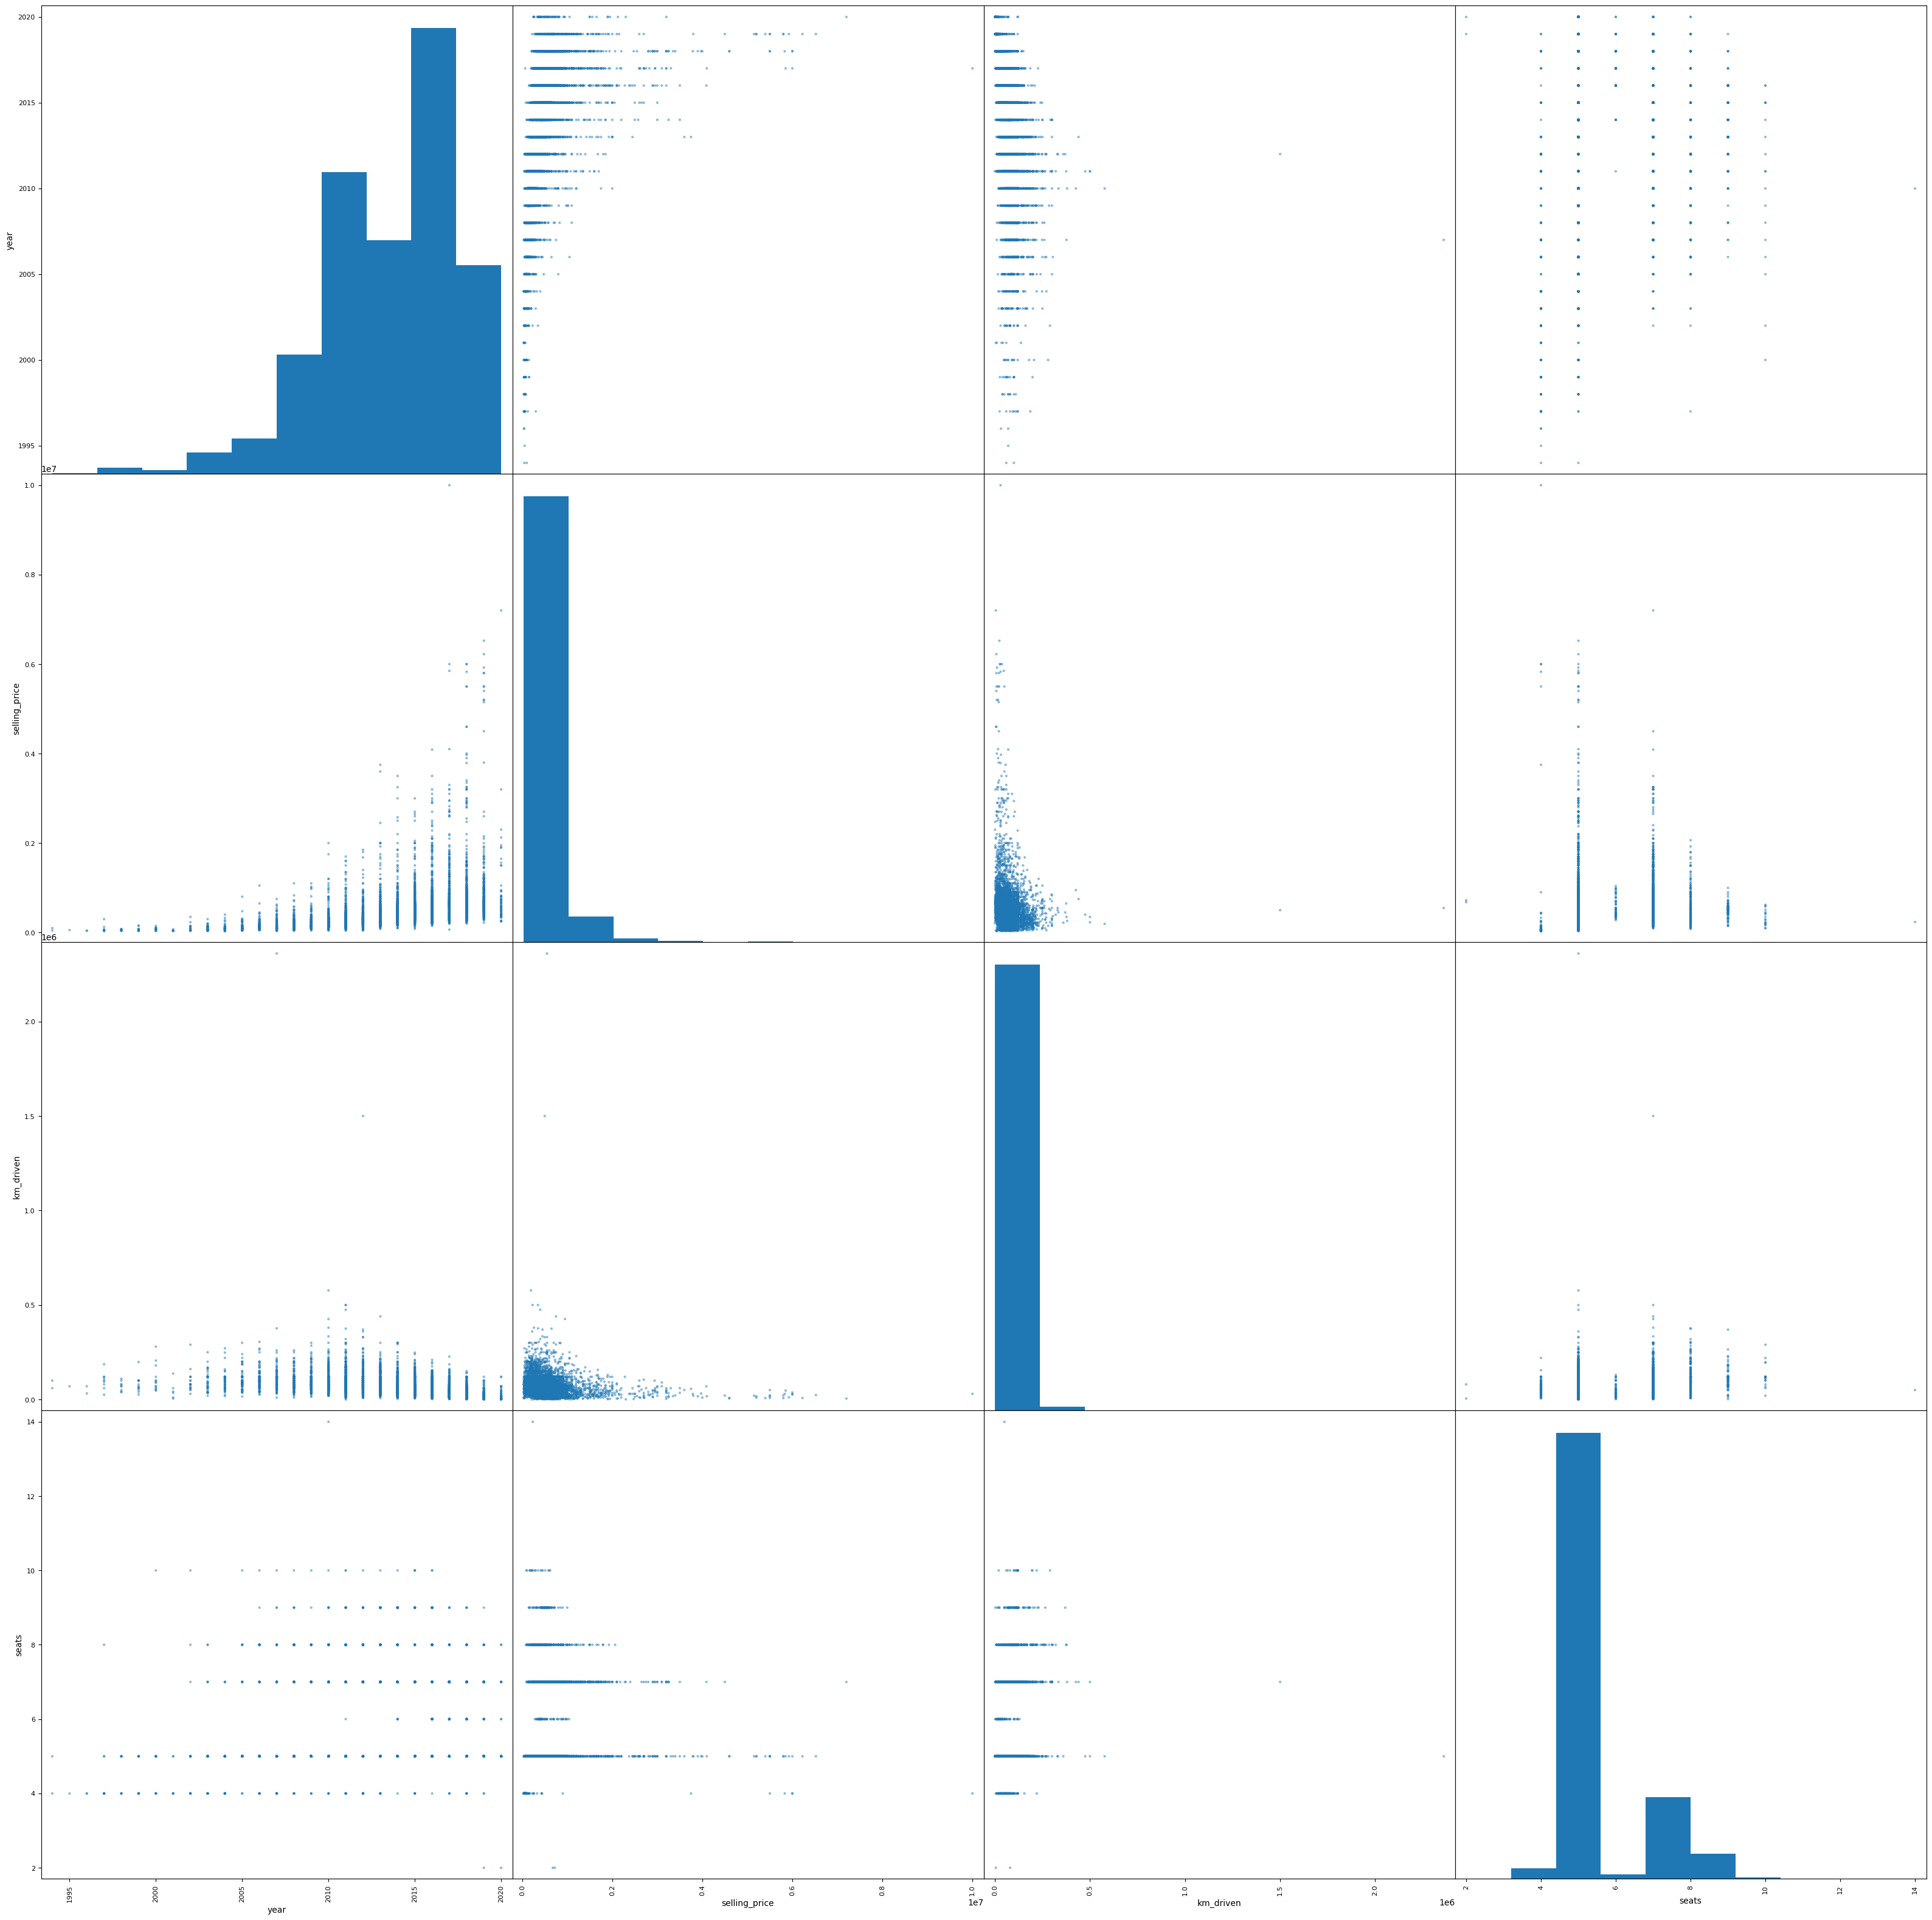

In [23]:
pd.plotting.scatter_matrix(df, figsize=(40,40));

### Data Preprocessing
In this stage we are cleaning the data and extracting features which could be useful from initial inspection.

Year and selling price show an interesting pattern, have to look more into it. Also selling price and seats show a pattern as well.

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,6717.0,2013.611136,3.897402,1994.0,2011.0,2014.0,2017.0,2020.0
selling_price,6717.0,526385.997022,523550.448297,29999.0,250000.0,420000.0,650000.0,10000000.0
km_driven,6717.0,73398.337651,58703.275270,1.0,38000.0,68203.0,100000.0,2360457.0
seats,6717.0,5.434271,0.983805,2.0,5.0,5.0,5.0,14.0


From this summary, we can see the minimum mileage is 0, which is not possible. So there must be some issue with this data. And also the minimum selling price of a car is 30k which is weird.

In [25]:
df.fuel = pd.Series(df.fuel, dtype='category')
df.seller_type = pd.Series(df.seller_type, dtype='category')
df.transmission =pd.Series(df.transmission, dtype='category')
df.owner = pd.Series(df.owner, dtype='category')
df.fuel.dtype
df.seller_type.dtype
df.transmission.dtype
df.owner.dtype

CategoricalDtype(categories=['First Owner', 'Fourth & Above Owner', 'Second Owner',
                  'Test Drive Car', 'Third Owner'],
, ordered=False)

In [26]:
df['fuel'].unique()

['Diesel', 'Petrol', 'LPG', 'CNG']
Categories (4, object): ['CNG', 'Diesel', 'LPG', 'Petrol']

In [27]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [28]:
df['mileage'] =  df['mileage'].str.extract('(\d+\.\d+)').astype(float)
df['engine'] =  df['engine'].str.extract('(\d+)').astype(int)
df['max_power'] =  df['max_power'].str.extract('(\d+.*\d+)').astype(float)
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


In [29]:
torqueData =  df['torque'].tolist()
i=0
newData=[]
newTorque=[]
newRpm=[]
for x in torqueData:
  i = i+1
  mult = 9.8 if 'gm' in x else 1
  newlist = re.findall("\d+[.,]*\d*", x)
  convertedTorque = float(newlist[0]) * mult
  newlist[0] = str(convertedTorque)
  newTorque.append(newlist[0])
  newRpm.append(newlist[-1])
  newData.append(newlist)
df.insert(8, "torque (Nm)", newTorque, True)
df.insert(9, "RPM", newRpm, True)

In [30]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,torque (Nm),RPM,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,190.0,2000,23.40,1248,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,250.0,2500,21.14,1498,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,124.46000000000001,"2,700",17.70,1497,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,219.52,2750,23.00,1396,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,112.7,"4,500",16.10,1298,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


In [31]:
df.drop('torque',inplace=True,axis=1)

In [32]:
df['torque (Nm)'] = pd.to_numeric(df['torque (Nm)'])
df['RPM'] = pd.to_numeric(df['RPM'],errors='coerce')
df.dropna(inplace=True)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 0 to 8125
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   name           6392 non-null   object  
 1   year           6392 non-null   int64   
 2   selling_price  6392 non-null   int64   
 3   km_driven      6392 non-null   int64   
 4   fuel           6392 non-null   category
 5   seller_type    6392 non-null   category
 6   transmission   6392 non-null   category
 7   owner          6392 non-null   category
 8   torque (Nm)    6392 non-null   float64 
 9   RPM            6392 non-null   float64 
 10  mileage        6392 non-null   float64 
 11  engine         6392 non-null   int64   
 12  max_power      6392 non-null   float64 
 13  seats          6392 non-null   float64 
dtypes: category(4), float64(5), int64(4), object(1)
memory usage: 574.9+ KB


In [34]:
def extractBrand(x):
  lb = str(x).split()
  return lb[0]
df['Brand'] = df['name'].apply(extractBrand)

In [35]:
len(df.name.unique())

1834

In [36]:
len(df.Brand.unique())

31

In [37]:
def extractModel(x):
  lb = str(x).split()
  model = " ".join(lb[1:])
  return model
df['Model'] = df['name'].apply(extractModel)

In [38]:
df[['name','Brand','Model']]

,name,Brand,Model
0,Maruti Swift Dzire VDI,Maruti,Swift Dzire VDI
1,Skoda Rapid 1.5 TDI Ambition,Skoda,Rapid 1.5 TDI Ambition
3,Hyundai i20 Sportz Diesel,Hyundai,i20 Sportz Diesel
5,Hyundai Xcent 1.2 VTVT E Plus,Hyundai,Xcent 1.2 VTVT E Plus
7,Maruti 800 DX BSII,Maruti,800 DX BSII
...,...,...,...
8120,Hyundai Santro Xing GLS,Hyundai,Santro Xing GLS
8121,Maruti Wagon R VXI BS IV with ABS,Maruti,Wagon R VXI BS IV with ABS
8122,Hyundai i20 Magna 1.4 CRDi,Hyundai,i20 Magna 1.4 CRDi
8123,Hyundai i20 Magna,Hyundai,i20 Magna


In [39]:
df['Age']=date.today().year-df['year']
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,torque (Nm),RPM,mileage,engine,max_power,seats,Brand,Model,Age
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,190.00,2000.0,23.40,1248,74.00,5.0,Maruti,Swift Dzire VDI,9
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,250.00,2500.0,21.14,1498,103.52,5.0,Skoda,Rapid 1.5 TDI Ambition,9
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,219.52,2750.0,23.00,1396,90.00,5.0,Hyundai,i20 Sportz Diesel,13
5,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,113.75,4000.0,20.14,1197,81.86,5.0,Hyundai,Xcent 1.2 VTVT E Plus,6
7,Maruti 800 DX BSII,2001,45000,5000,Petrol,Individual,Manual,Second Owner,59.00,2500.0,16.10,796,37.00,4.0,Maruti,800 DX BSII,22


### Exploratory Data Analysis
Here we visually explore the data and try to find useful relations

Text(0.5, 1.0, 'Top 10 Car brands for sale')

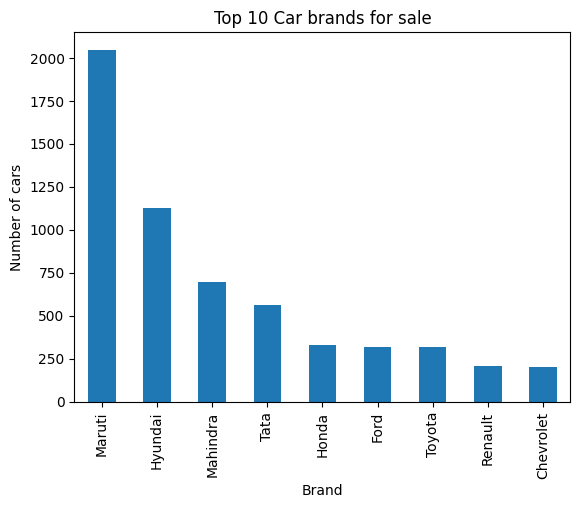

In [40]:
df.groupby('Brand').count().name.sort_values(ascending=False)[0:9].plot.bar()
plt.ylabel('Number of cars')
plt.title("Top 10 Car brands for sale")

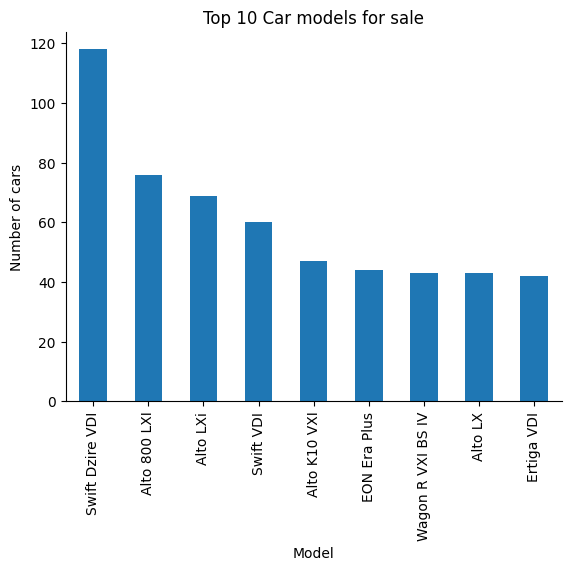

In [41]:
df.groupby('Model').count().name.sort_values(ascending=False)[0:9].plot.bar()
plt.ylabel('Number of cars')
plt.title("Top 10 Car models for sale")
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-42-7a4b4562b3c9>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Brand').mean().selling_price.sort_values(ascending=True).plot.barh()


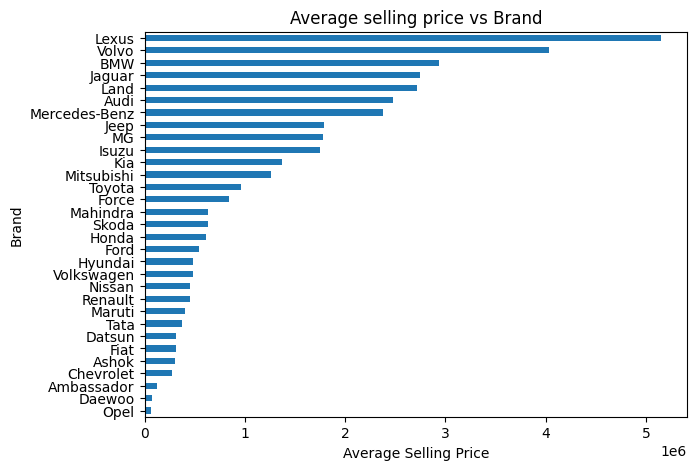

In [42]:
plt.figure(figsize=(7,5))
df.groupby('Brand').mean().selling_price.sort_values(ascending=True).plot.barh()
plt.xlabel('Average Selling Price')
plt.title('Average selling price vs Brand');

In [43]:
# Classifying the brands into 3 categories: Premium, Medium and Base

sl_p = df.groupby('Brand')

limits=[1.74e+06,4.496941e+05]


In [44]:
brand = df.Brand.unique()
brand = np.sort(brand)
price = sl_p.mean().selling_price
premium_brands = brand[price > limits[0]]
medium_brands = brand[(price <= limits[0]) & (price > limits[1])]
base_brands = brand[price <= limits[1]]

<ipython-input-44-38d470144484>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  price = sl_p.mean().selling_price


In [45]:
def transformBrand(br):
  if br in premium_brands:
    return 'Premimum'
  elif br in medium_brands:
    return 'Medium'
  else:
    return 'Base'

df['Brand_Type'] = df.Brand.apply(transformBrand)
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,torque (Nm),RPM,mileage,engine,max_power,seats,Brand,Model,Age,Brand_Type
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,190.00,2000.0,23.40,1248,74.00,5.0,Maruti,Swift Dzire VDI,9,Base
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,250.00,2500.0,21.14,1498,103.52,5.0,Skoda,Rapid 1.5 TDI Ambition,9,Medium
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,219.52,2750.0,23.00,1396,90.00,5.0,Hyundai,i20 Sportz Diesel,13,Medium
5,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,113.75,4000.0,20.14,1197,81.86,5.0,Hyundai,Xcent 1.2 VTVT E Plus,6,Medium
7,Maruti 800 DX BSII,2001,45000,5000,Petrol,Individual,Manual,Second Owner,59.00,2500.0,16.10,796,37.00,4.0,Maruti,800 DX BSII,22,Base


In [46]:
df.describe()

,year,selling_price,km_driven,torque (Nm),RPM,mileage,engine,max_power,seats,Age
count,6392.000000,6.392000e+03,6.392000e+03,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000
mean,2013.893773,5.420580e+05,7.189985e+04,172.959260,3036.010325,19.640186,1426.544587,87.846151,5.441489,9.106227
std,3.742303,5.293995e+05,5.898207e+04,100.905981,900.846538,4.046577,498.176125,31.904397,0.980654,3.742303
min,1994.000000,2.999900e+04,1.000000e+00,14.900000,400.000000,0.000000,624.000000,32.800000,2.000000,3.000000
25%,2012.000000,2.700000e+05,3.500000e+04,110.000000,2250.000000,17.000000,1196.000000,67.100000,5.000000,6.000000
50%,2014.000000,4.389990e+05,6.500000e+04,170.000000,3000.000000,19.700000,1248.000000,81.860000,5.000000,9.000000
75%,2017.000000,6.500000e+05,1.000000e+05,200.000000,4000.000000,22.700000,1498.000000,100.000000,5.000000,11.000000
max,2020.000000,1.000000e+07,2.360457e+06,3724.000000,5300.000000,42.000000,3604.000000,400.000000,14.000000,29.000000


<Axes: ylabel='Frequency'>

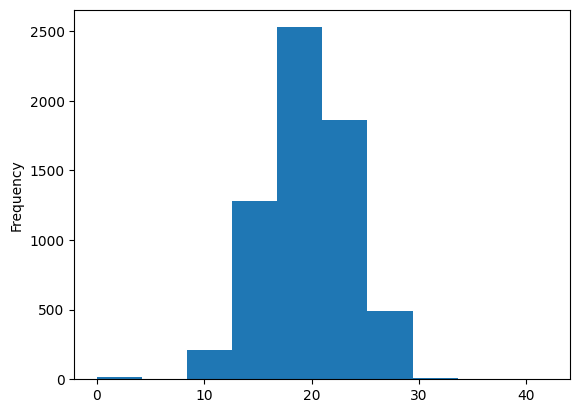

In [47]:
# Finding the distribution of the mileage variable

df.mileage.plot.hist()

In [48]:
# Looking for the data with 0 mileage
df[df.mileage == 0].mileage.count()

14

In [49]:
# Removing those outliers in mileage

df = df[df.mileage != 0]
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,torque (Nm),RPM,mileage,engine,max_power,seats,Brand,Model,Age,Brand_Type
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,190.00,2000.0,23.40,1248,74.00,5.0,Maruti,Swift Dzire VDI,9,Base
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,250.00,2500.0,21.14,1498,103.52,5.0,Skoda,Rapid 1.5 TDI Ambition,9,Medium
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,219.52,2750.0,23.00,1396,90.00,5.0,Hyundai,i20 Sportz Diesel,13,Medium
5,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,113.75,4000.0,20.14,1197,81.86,5.0,Hyundai,Xcent 1.2 VTVT E Plus,6,Medium
7,Maruti 800 DX BSII,2001,45000,5000,Petrol,Individual,Manual,Second Owner,59.00,2500.0,16.10,796,37.00,4.0,Maruti,800 DX BSII,22,Base


In [50]:
# Removing with seat numbers greater than 9

df = df[df.seats<=9]

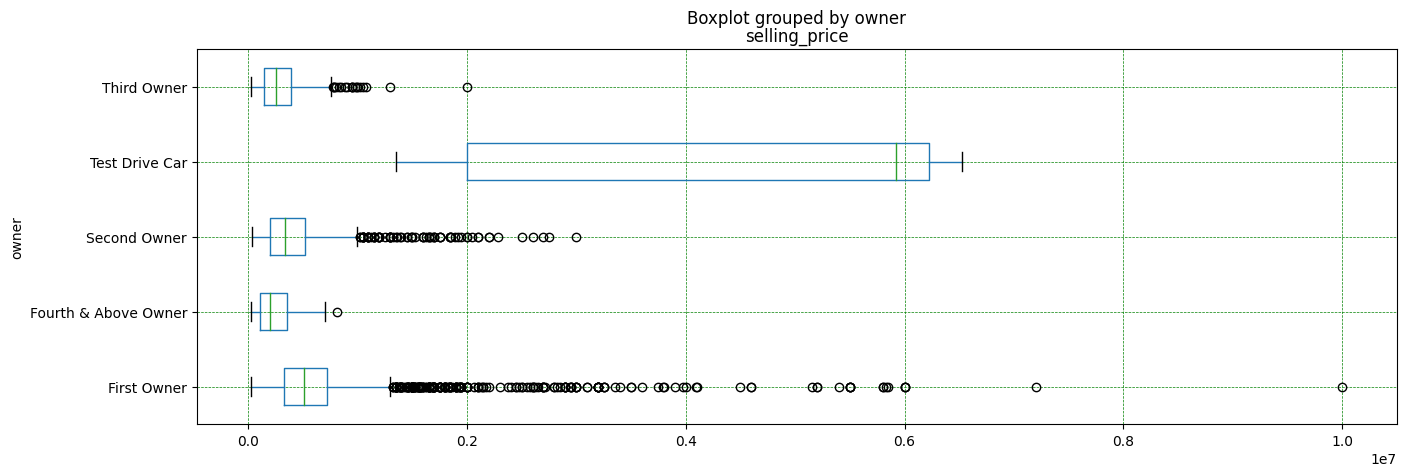

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))
df.boxplot('selling_price', by='owner', ax=ax, vert=0);
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

In [52]:
df[df.owner=="Test Drive Car"]
# Dilemma : Should we remove this category of owner?

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,torque (Nm),RPM,mileage,engine,max_power,seats,Brand,Model,Age,Brand_Type
4383,Volkswagen Vento 1.5 TDI Highline BSIV,2019,1350000,5400,Diesel,Dealer,Manual,Test Drive Car,250.0,3000.0,22.27,1498,108.60,5.0,Volkswagen,Vento 1.5 TDI Highline BSIV,4,Medium
4950,Audi A6 35 TFSI Matrix,2019,6223000,7800,Petrol,Dealer,Automatic,Test Drive Car,320.0,4100.0,15.26,1798,187.74,5.0,Audi,A6 35 TFSI Matrix,4,Premimum
4951,Audi A6 35 TFSI Matrix,2019,5923000,11500,Petrol,Dealer,Automatic,Test Drive Car,320.0,4100.0,15.26,1798,187.74,5.0,Audi,A6 35 TFSI Matrix,4,Premimum
4952,Audi A6 35 TFSI Matrix,2019,6523000,23600,Petrol,Dealer,Automatic,Test Drive Car,320.0,4100.0,15.26,1798,187.74,5.0,Audi,A6 35 TFSI Matrix,4,Premimum
6220,Honda Civic ZX,2019,2000000,24857,Petrol,Dealer,Automatic,Test Drive Car,174.0,4300.0,16.50,1799,139.46,5.0,Honda,Civic ZX,4,Medium


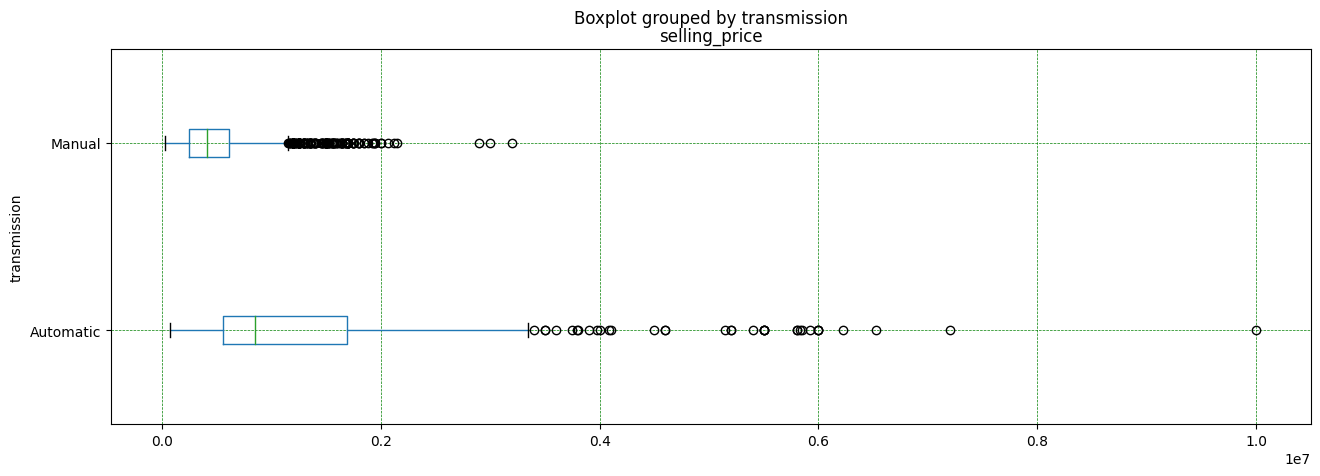

In [53]:
fig, ax = plt.subplots(figsize=(15, 5))
df.boxplot('selling_price', by='transmission', ax=ax, vert=0);
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

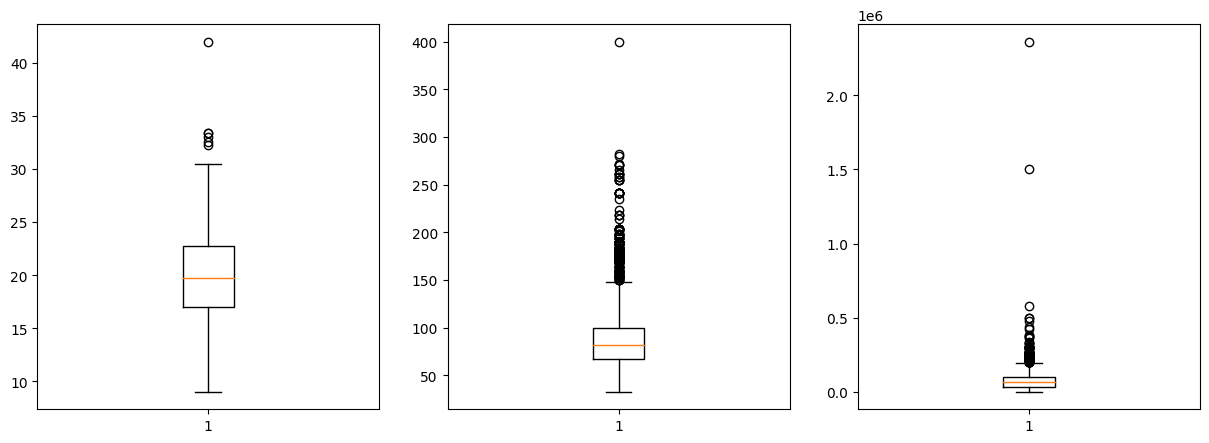

In [54]:
fig, ax = plt.subplots(1,3,figsize=(15, 5))
ax[0].boxplot(df.mileage.to_list());
ax[1].boxplot(df.max_power.to_list());
ax[2].boxplot(df.km_driven.to_list());

<Axes: xlabel='seller_type'>

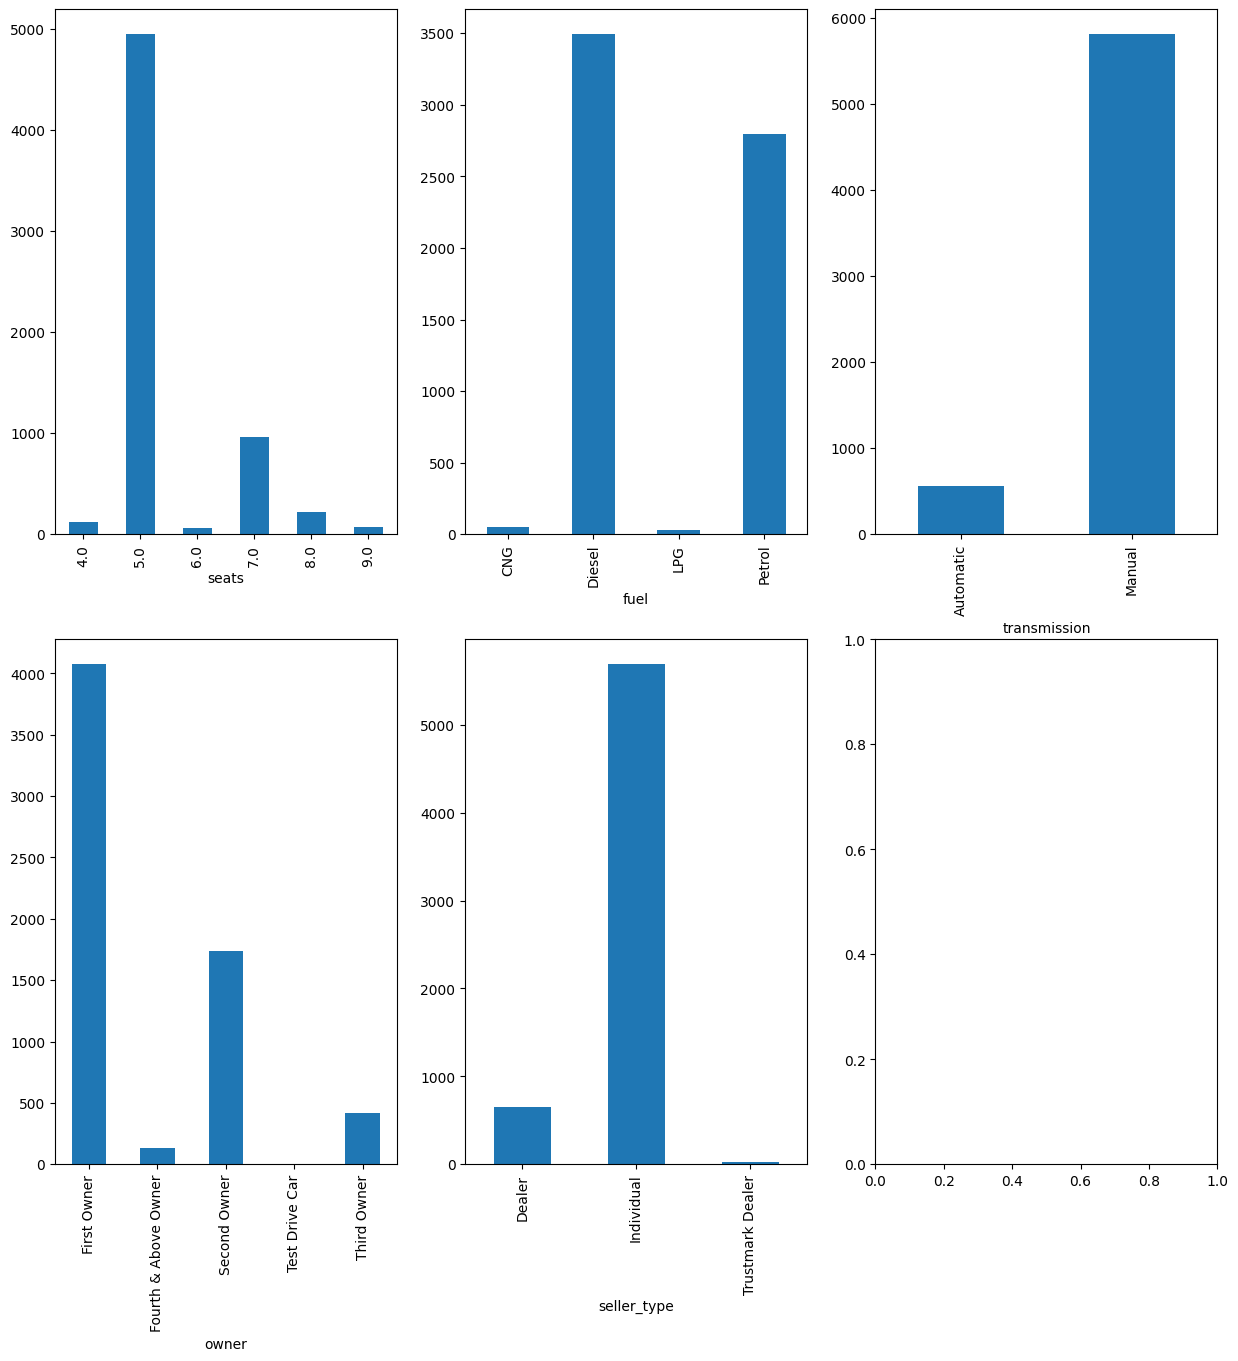

In [55]:
fig, ax = plt.subplots(2,3,figsize=(15, 15))
df.groupby('seats').count().name.plot.bar(ax=ax[0,0])
df.groupby('fuel').count().name.plot.bar(ax=ax[0,1])
df.groupby('transmission').count().name.plot.bar(ax=ax[0,2])
df.groupby('owner').count().name.plot.bar(ax=ax[1,0])
df.groupby('seller_type').count().name.plot.bar(ax=ax[1,1])

<Axes: xlabel='log_sell', ylabel='km_driven'>

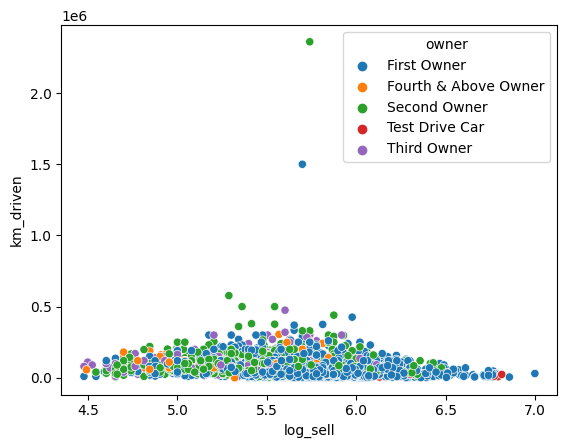

In [56]:
df['log_sell'] = np.log10(df.selling_price)
sns.scatterplot(x='log_sell',y='km_driven',hue='owner',data=df)

<Axes: xlabel='selling_price', ylabel='torque (Nm)'>

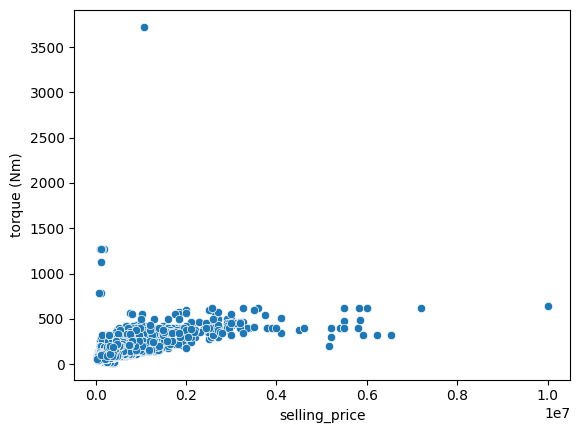

In [57]:
sns.scatterplot(x='selling_price',y='torque (Nm)',data=df)

<ipython-input-58-041daa03acff>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),cmap='viridis')


<Axes: >

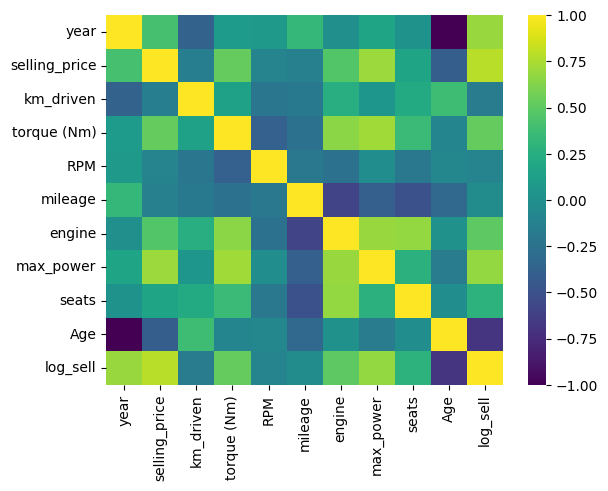

In [58]:
sns.heatmap(df.corr(),cmap='viridis')

In [59]:
data = df

In [60]:
data.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'torque (Nm)', 'RPM', 'mileage', 'engine',
       'max_power', 'seats', 'Brand', 'Model', 'Age', 'Brand_Type',
       'log_sell'],
      dtype='object')

In [61]:
df.corr().selling_price

<ipython-input-61-67a5a54cf195>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().selling_price


year             0.410847
selling_price    1.000000
km_driven       -0.149913
torque (Nm)      0.530179
RPM             -0.099147
mileage         -0.139722
engine           0.455805
max_power        0.701785
seats            0.167013
Age             -0.410847
log_sell         0.784418
Name: selling_price, dtype: float64

In [62]:
#profile = ProfileReport(df, title="Profile Report", explorative=True)

In [63]:
#profile.to_widgets()

In [64]:
#profile.to_file("report.html")

### Modelling and Interpretation

In [65]:
df = pd.concat([df.drop('fuel',axis=1),pd.get_dummies(df.fuel,drop_first=True)],axis=1)
df = pd.concat([df.drop('seller_type',axis=1),pd.get_dummies(df.seller_type,drop_first=True)],axis=1)
df = pd.concat([df.drop('transmission',axis=1),pd.get_dummies(df.transmission,drop_first=True)],axis=1)
df = pd.concat([df.drop('owner',axis=1),pd.get_dummies(df.owner,drop_first=True)],axis=1)

In [66]:
# df = pd.concat([df.drop('Brand',axis=1),pd.get_dummies(df.Brand,drop_first=True)],axis=1)
df = pd.concat([df.drop(['Brand','Brand_Type'],axis=1),pd.get_dummies(df.Brand_Type,drop_first=True)],axis=1)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6368 entries, 0 to 8125
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  6368 non-null   object 
 1   year                  6368 non-null   int64  
 2   selling_price         6368 non-null   int64  
 3   km_driven             6368 non-null   int64  
 4   torque (Nm)           6368 non-null   float64
 5   RPM                   6368 non-null   float64
 6   mileage               6368 non-null   float64
 7   engine                6368 non-null   int64  
 8   max_power             6368 non-null   float64
 9   seats                 6368 non-null   float64
 10  Model                 6368 non-null   object 
 11  Age                   6368 non-null   int64  
 12  log_sell              6368 non-null   float64
 13  Diesel                6368 non-null   uint8  
 14  LPG                   6368 non-null   uint8  
 15  Petrol               

In [68]:
df_n = df.drop(['name','Model','log_sell','year','name'],axis=1)

In [69]:
renamed_columns = {'First Owner': 'first_own',
                   'Fourth & Above Owner': 'fourth_own',
                   'Second Owner': 'second_own',
                   'Test Drive Car':'test_drive_car',
                   'Third Owner': 'third_own',
                   'torque (Nm)':'torque',
                   'Trustmark Dealer' : 'TrustMark_Dealer'
                   }
df.rename(columns=renamed_columns,inplace=True)
df_n.rename(columns=renamed_columns,inplace=True)
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'torque', 'RPM',
       'mileage', 'engine', 'max_power', 'seats', 'Model', 'Age', 'log_sell',
       'Diesel', 'LPG', 'Petrol', 'Individual', 'TrustMark_Dealer', 'Manual',
       'fourth_own', 'second_own', 'test_drive_car', 'third_own', 'Medium',
       'Premimum'],
      dtype='object')

In [70]:
df_n.columns

Index(['selling_price', 'km_driven', 'torque', 'RPM', 'mileage', 'engine',
       'max_power', 'seats', 'Age', 'Diesel', 'LPG', 'Petrol', 'Individual',
       'TrustMark_Dealer', 'Manual', 'fourth_own', 'second_own',
       'test_drive_car', 'third_own', 'Medium', 'Premimum'],
      dtype='object')

In [71]:
# Finding relation with customer type

m_cust = ols('selling_price ~ third_own + fourth_own + second_own ',data=df).fit()
print(m_cust.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     122.9
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           2.14e-77
Time:                        09:39:35   Log-Likelihood:                -92774.
No. Observations:                6368   AIC:                         1.856e+05
Df Residuals:                    6364   BIC:                         1.856e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.313e+05   8048.341     78.443      0.0

**Interpretation**:

Here all the variables have significant p values. If one buys a 2nd hand car in place of a 1st hand, he will have to pay &#8377;2,20,000 less on average and for 3rd hand it will be &#8377;3,24,400 less than a 1st hand car on average.

In [72]:
# Creating a model with all the possible predictors

all_columns = "+".join(df_n.columns.difference(["selling_price"]))
formula = 'selling_price ~ '+all_columns
full_model = ols(formula,data=df_n).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     803.8
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        09:39:36   Log-Likelihood:                -88935.
No. Observations:                6368   AIC:                         1.779e+05
Df Residuals:                    6347   BIC:                         1.781e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3.841e+05   8.48e+04  

### Questions answered using the Data

In this section, we try to ask some questions and solve them using the data at hand to get more insights about the customers, market and cars.

#### Effect of ageing on cars with different fuel types.

In [73]:
## Question: How much age affects price of LPG, CNG, Petrol and Diesel Cars does it affect them the same?

mod = ols('selling_price ~ Age + LPG + Diesel + Petrol',data=df_n).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     465.3
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        09:39:36   Log-Likelihood:                -92136.
No. Observations:                6368   AIC:                         1.843e+05
Df Residuals:                    6363   BIC:                         1.843e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.509e+05   6.68e+04     11.234      0.0

Text(0, 0.5, 'Average Selling Price')

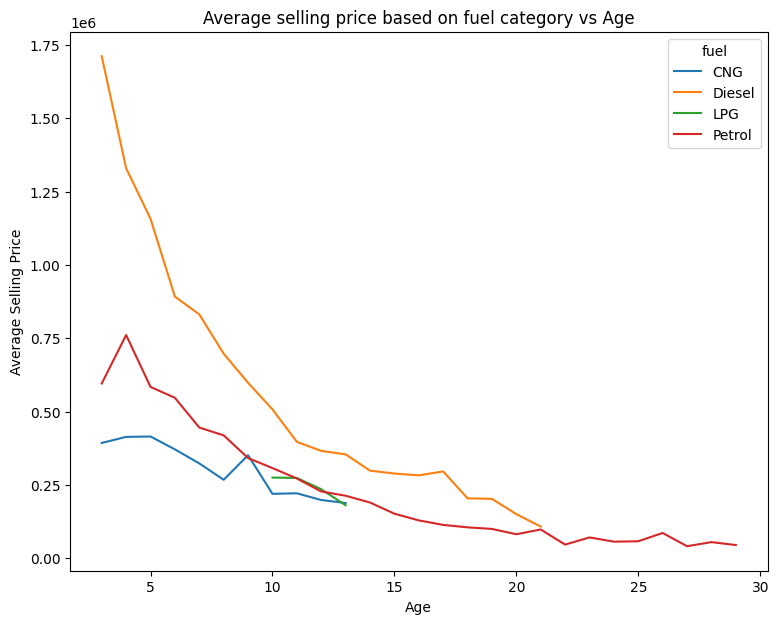

In [74]:
dfp = data.pivot_table(index='Age', columns='fuel', values='selling_price', aggfunc='mean')
dfp.plot(kind='line', figsize=(9, 7))
plt.title('Average selling price based on fuel category vs Age')
plt.ylabel('Average Selling Price')

**Claim:**

From the above visualization, Diesel cars seem to have the worst effect due to ageing

In [78]:
data['Age'] = df_n['Age']

We might look to answer this question using the following method:

1. _Two - way ANOVA_: To find if there is significant difference due to the two categories.
2. _Interaction Terms_: We check the coefficients for the interaction terms.

In [81]:
# Two way ANOVA
model = ols('selling_price ~ C(fuel) + C(Age) + C(fuel):C(Age)',
            data=data).fit()
result = anova_lm(model,type=2)
print(result)

                    df        sum_sq       mean_sq           F         PR(>F)
C(fuel)            3.0  1.175912e+14  3.919708e+13  194.220083  1.794960e-120
C(Age)            26.0  3.472719e+14  1.335661e+13   66.181518  8.470630e-306
C(fuel):C(Age)    78.0  5.010582e+13  6.423823e+11    3.182981   3.919562e-19
Residual        6303.0  1.272058e+15  2.018178e+11         NaN            NaN


From the Two way ANOVA test we see that that is significant difference in selling price due to both fuel type of the car as well as the Age of the car,which we found earlier as well. But now we find even the interaction term showing a significant impact on the price of the car.

In [85]:
# Interaction Terms
model = ols('selling_price ~ C(fuel) + Age + C(fuel):Age',
            data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     312.8
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:06:57   Log-Likelihood:                -92011.
No. Observations:                6368   AIC:                         1.840e+05
Df Residuals:                    6360   BIC:                         1.841e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              5.163e+

We see that the coefficient term for the diesel and age interaction is a significant one and has the most value (negative).
So we can conclude that aging has the worst effect on Diesel cars, then followed by LPG, Petrol and CNG.


#### Combined effect of age and kms driven on the price on the car.